Todo for next session:
- Comentarii la cod, structura lui, main parts ca si headers cum e acum: 1., 2. dar mai in detaliu
- Implementat algoritmul din paper in cadrul unei operatii de convolutie custom 
- Facem si partea de img fusion sau ramanem la segmentare pe baza focus??
- Metoda obiectiva de avaluare a rezultatelor: cautat metrici pentru a masura asta

Nice to have:
- Scriem functiile in module, si in jupyter doar le importam si exemplificam ce fac
- Raport tehnic, + update la ppt

In [32]:
# !./load_data.sh

## 1. Load images and process color channels

In [33]:
from pathlib import Path
import os
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

In [34]:
DATA_PATH = Path.cwd() / 'data' 
DATA_PATH.as_posix()

'/home/astanea/code/image_processing/Image-Processing/data'

In [35]:
def get_random_img_path(data_path):
    return data_path / np.random.choice(os.listdir(data_path))

In [36]:
def get_images(path: str) -> np.ndarray:
    images = []
    for img in Path(path).glob('*.jpg'):
        img = cv.imread(str(img))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        images.append(img)
    return np.array(images)   

images = get_images(get_random_img_path(DATA_PATH).as_posix())
len(images)

2

In [37]:
images.shape

(2, 427, 640, 3)

In [38]:
def plot_images(images: np.ndarray):
    """Takes a list of images and plots them in a row, inside the same figure

    Args:
        images (np.ndarray): list containing images to be plotted as numpy arrays
    """
    num_images = len(images)
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # If there's only one row and one column, axes is not an array
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])

    # If there's only one row, axes is a 1D array
    elif rows == 1:
        axes = np.array([axes])

    for ax, img in zip(axes.ravel(), images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

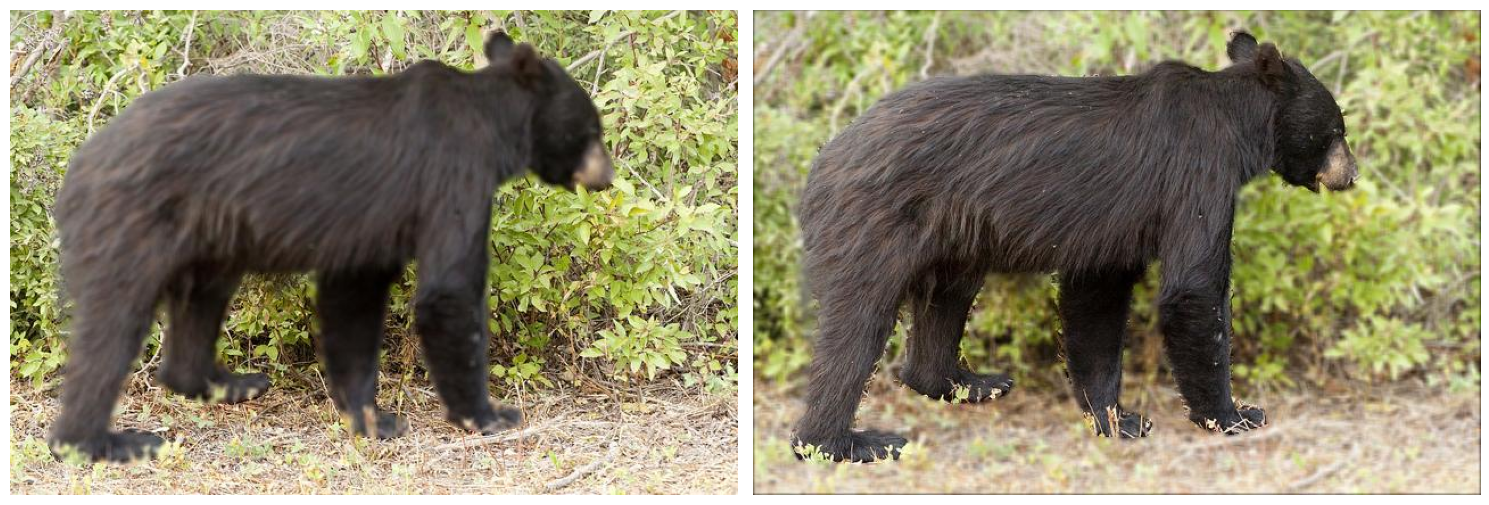

In [39]:
# plot_images(images[:, :, :, 2])
plot_images(images)

## TESTING AREA

In [48]:
grayscale_imgages = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


# Algorithm implementation

## Sum of the Gaussian-based modified Laplacian

TODO: describe what a kernel is, gaussian distribution and the visualizations below
TODO: add .ini file with hyperparameters

In [40]:
def convolution_iterator(img: np.ndarray, kernel, verbose=False):
    # img : 2D image -> W x H
    height_img, width_img = img.shape
    height_kernel, width_kernel = kernel
    
    if verbose:
        print(f"kernel_shape: {kernel.shape}")
        print(f"img shape: {img.shape}")

    # Loop through each pixel in the image skipping the outer edges of the image
    for y in range(height_kernel // 2, 
                   height_img - height_kernel // 2 - 1):
        for x in range(width_kernel // 2, 
                       width_img - width_kernel // 2 - 1):
            window = img[
                y - height_kernel // 2 : y + height_kernel // 2 + 1,
                x - width_kernel // 2 : x + width_kernel // 2 + 1,
            ]
            
            yield (y, x, window)


Compute the ML to extract edge information without loosing information when terms might cancel each other
- Based on reference [5] from our paper, the ML is computed over a window with size=3

In [41]:
kernel_size = 7
padding = (kernel_size - 1) // 2

def pad_images(images: np.ndarray, padding: int, border=cv.BORDER_CONSTANT):
    """Takes a list of images and pads them with zeros

    Args:
        images (np.ndarray): list containing images to be padded as numpy arrays
        padding (int): padding to be applied to each image
    
    Returns:
        np.ndarray: padded images
    """
    padded_images = []
    
    for idx, img in enumerate(images):
        replicate = cv.copyMakeBorder(img,padding,padding,padding,padding, border,value=0)
        padded_images.append(replicate)
        
    return np.array(padded_images)

In [42]:
padded_images = pad_images(images, padding, cv.BORDER_CONSTANT)

In [43]:
images.shape, padded_images.shape

((2, 427, 640, 3), (2, 433, 646, 3))

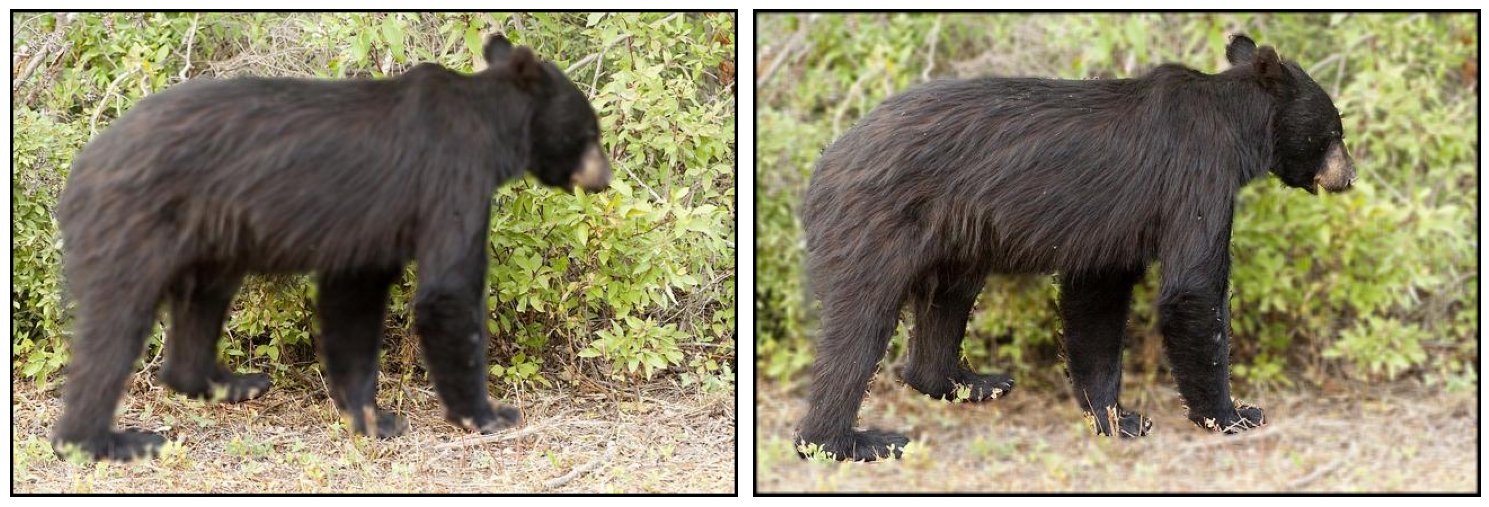

In [44]:
plot_images(padded_images)

In [45]:
def ML(images, step_size=1):
    # TODO: check that the step size wont cause the window to go out of bounds
    grayscale_imgages cv.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ml_images = []
    for idx, img in enumerate(images):
        crnt_img = []
        for img_color_chn in cv.split(img):
            print(f"img_color_chn shape: {img_color_chn.shape}")
            
            ml_img_color_chn = np.zeros_like(img_color_chn)
            print(ml_img_color_chn.shape)
            
            for y, x, window in convolution_iterator(img_color_chn, (7,7)):
                ml_img_color_chn[y, x] = np.abs(2*img_color_chn[y,x] - img_color_chn[y-step_size,x] - img_color_chn[y+step_size,x]) + \
                                         np.abs(2*img_color_chn[y,x] - img_color_chn[y,x-step_size] - img_color_chn[y,x+step_size])
            
            # add the cropped color channel to the current image
            crnt_img.append(ml_img_color_chn) 
        ml_images.append(cv.merge(crnt_img))
    return np.array(ml_images)

SyntaxError: invalid syntax (353722655.py, line 3)

In [ ]:
ml_images = ML(padded_images)
ml_images.shape

img_color_chn shape: (206, 306)
(206, 306)


img_color_chn shape: (206, 306)
(206, 306)
img_color_chn shape: (206, 306)
(206, 306)
img_color_chn shape: (206, 306)
(206, 306)
img_color_chn shape: (206, 306)
(206, 306)
img_color_chn shape: (206, 306)
(206, 306)


(2, 206, 306, 3)

In [ ]:
padded_images.shape,  images.shape, ml_images.shape

((2, 206, 306, 3), (2, 200, 300, 3), (2, 206, 306, 3))

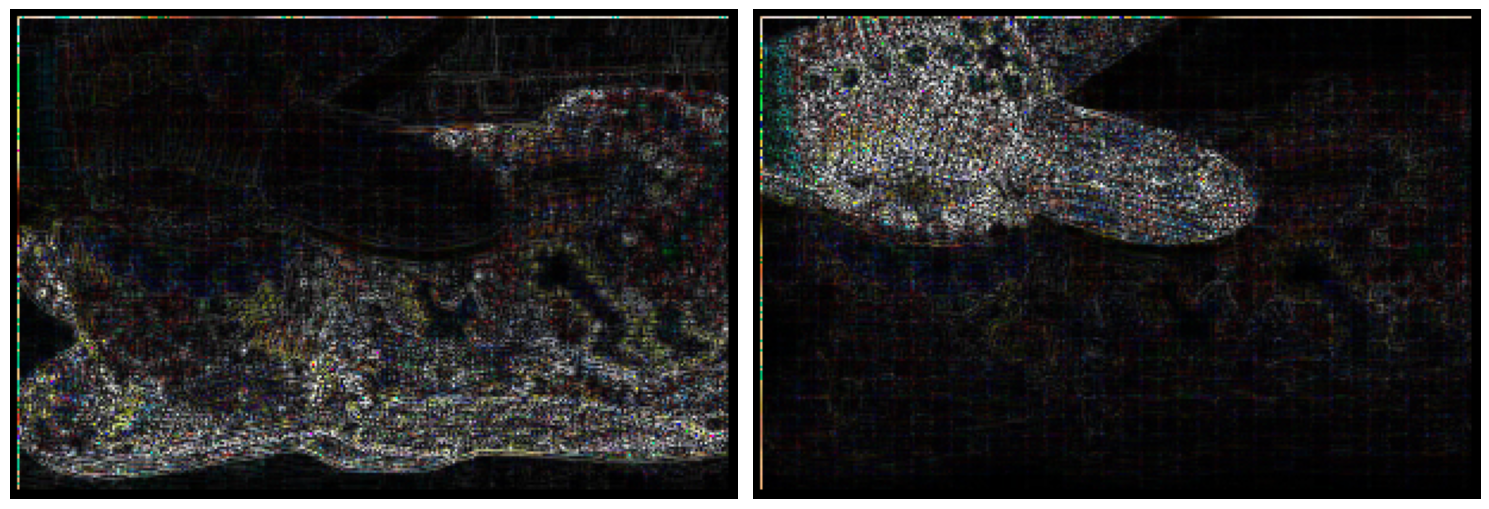

In [ ]:
# View result of the ML
COLOR_CHN = 1
plot_images(ml_images)
# plot_images(ml_images[:, :, :, COLOR_CHN])

In [ ]:
def SGML(ml_images, window_size=7, crop_size=padding):
    sigma=2
    threshold=0
    
    gaussian_kernel_1D = cv.getGaussianKernel(window_size, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())
    
    sgml_images = []
    for idx, img in enumerate(ml_images):
        crnt_img = []
        for img_color_chn in cv.split(img):
            ml_img_color_chn = np.zeros_like(img_color_chn)
            for y, x, window in convolution_iterator(img_color_chn, gaussian_kernel_2d.shape):
                crnt_step = (window * gaussian_kernel_2d)
                 
                # ml_img_color_chn[y, x] = np.sum(np.array(crnt_step > threshold))
                ml_img_color_chn[y, x] = np.sum(crnt_step)

            # add the cropped color channel to the current image
            crnt_img.append(ml_img_color_chn[crop_size:-crop_size, crop_size:-crop_size]) 
        sgml_images.append(cv.merge(crnt_img))
        
    return np.array(sgml_images)
    

In [ ]:
sgml_maps = SGML(ml_images)

In [ ]:
sgml_maps.shape, images.shape, sgml_maps.min(), sgml_maps.max()

((2, 200, 300, 3), (2, 200, 300, 3), 0, 139)

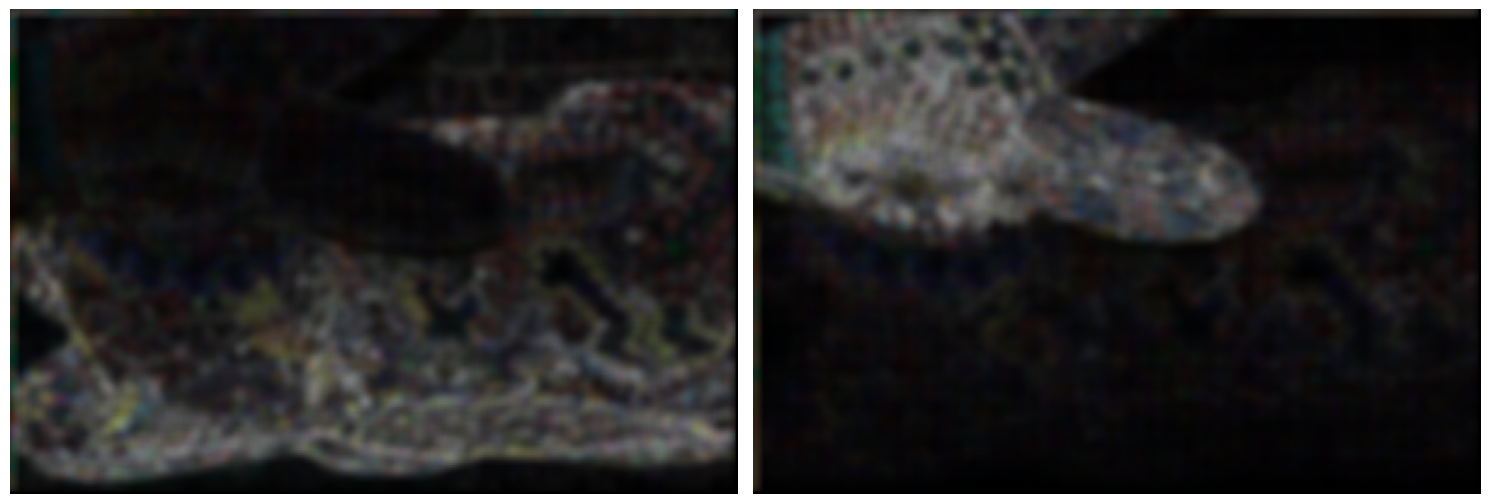

In [ ]:
# View result of the ML
COLOR_CHN = 1
plot_images(sgml_maps)

In [ ]:
assert 1 == 2, "Error: this is a test"

AssertionError: Error: this is a test

## Strategy of initial segmentation

In [ ]:
def compute_focus_score_maps(sgml_maps, patch_size=8, step_size=1):
    focus_socre_maps = np.zeros_like(sgml_maps)
    patch = np.ones((patch_size,patch_size))
    
    height_img, width_img, _ = sgml_maps[0].shape
    
    # Sliding window over the image
    for y in range(patch_size // 2, 
                   height_img - patch_size // 2 - 1,
                   step_size):
        for x in range(patch_size // 2, 
                       width_img - patch_size // 2 - 1,
                       step_size):
            window = sgml_maps[
                :, # both images
                y - patch_size // 2 : y + patch_size // 2 + 1,
                x - patch_size // 2 : x + patch_size // 2 + 1,
                :  # all color channels
            ]
            
            # compute sum in the current patch -> the results are 2 images with all the color channels
            k = np.sum(window, axis=(1,2)) 
            focus_socre_maps[:, y, x, :] = k
            
    F1, F2 = focus_socre_maps
    print(f"F1 shape: {F1.shape}")
    print(f"F2 shape: {F2.shape}")
    
    segmentation_maps = np.ones((2, F1.shape[0], F1.shape[1])) * 0.5
    
    I1_IDX, I2_IDX = range(2)
    
    for y in range(len(F1)): # rows
        for x in range(len(F1[y])): # cols
            if F2[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 1
                segmentation_maps[I2_IDX, y, x] = 0
            elif F1[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 0
                segmentation_maps[I2_IDX, y, x] = 1
                
    return segmentation_maps
            
            

In [ ]:
segmentation_maps = compute_focus_score_maps(sgml_maps)

F1 shape: (200, 300, 3)
F2 shape: (200, 300, 3)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
segmentation_maps.shape

In [ ]:
assert 1 == 2, "Error: this is a test"

## Image mating technique for fusion

In [ ]:
assert 1 == 2, "Error: this is a test"

In [ ]:
a=list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# OFFICIAL CV2 IMPLEMENTATION
kernel_size = 7
sigma = 2 
gaussian_kernel_1D = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())

print(f"gaussian_kernel_1D shape: {gaussian_kernel_1D.shape}")
print(f"gaussian_kernel_2d shape: {gaussian_kernel_2d.shape}")

NameError: name 'cv2' is not defined

In [ ]:
def plot_kernel_1D(kernel):
    plt.figure()
    plt.plot(kernel)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Representation of 1D Kernel')
    plt.show()
    
def plot_kernel_2D(kernel):
    # Create the x and y coordinate arrays
    x = np.arange(kernel.shape[0])
    y = np.arange(kernel.shape[1])
    x, y = np.meshgrid(x, y)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x, y, kernel, cmap='viridis')

    # Labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Kernel Value')
    ax.set_title('3D Representation of 2D Kernel')

    # Show the plot
    plt.show()    

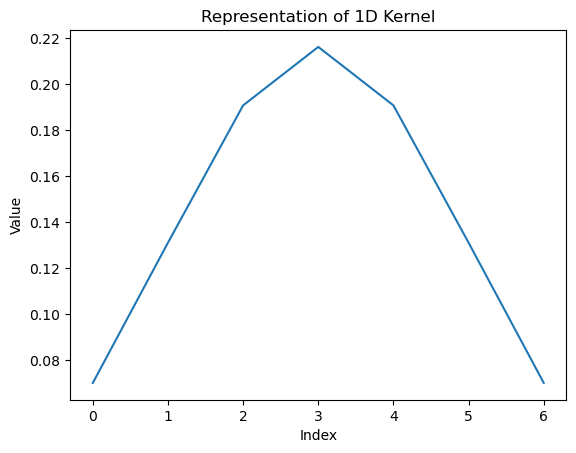

In [ ]:
plot_kernel_1D(gaussian_kernel_1D)

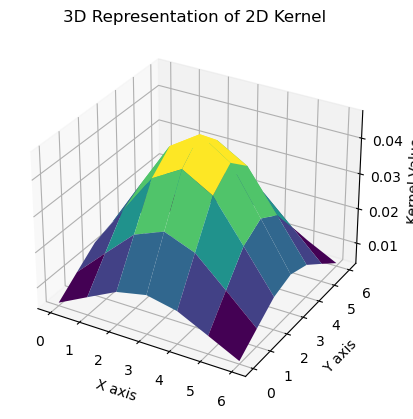

In [ ]:
plot_kernel_2D(gaussian_kernel_2d)

In [ ]:
def ML(img, s=1):
    
    pass

In [ ]:
def SGML(img=None, sigma=2, kernel_size=7):
    """Applies the Sum of the Gaussian-based modified Laplacian (SGML) filter to the input image

    Args:
        img (np.ndarray): image to be filtered
        sigma (int, optional): standard deviation of the Gaussian Kernel. Defaults to 2.
        r (int, optional): kernel size. Defaults to 7.

    Returns:
        np.ndarray: filtered image
    """
    assert kernel_size%2 == 1 and kernel_size > 1, "kernel_size must be an odd number greater than 1"
    assert sigma > 0, "sigma must be greater than 0"
    

# Paper implementation of algorithm: image focus score

## References:
- https://github.com/OmarMSaad/1D-Modified-Laplacian-of-Gaussian-Filter-for-Smoothing-and-Denoising-/tree/master